# How Below Is Well Below median probability relationships
This file takes both the AR6 and SR1.5 databases and finds relationships between the expected (median) warming and the exceedance quantiles for given temperatures. 

It expects to find the metadata for both available in the input folder. These files can be downloaded from 
https://data.ece.iiasa.ac.at/ar6/ and https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/.

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam

from labellines import labelLines
from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [2]:
# Define useful parameters for plotting
font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [3]:
fairexceed2c = 'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|FAIR'
magiccexceed2c = 'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6'
fairmed = 'AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED'
magiccmed = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'
ar6fairexceed2c = 'Exceedance Probability 2.0C (FaIRv1.6.2)'
ar6magiccexceed2c = 'Exceedance Probability 2.0C (MAGICCv7.5.3)'
ar6fairmed = 'Median peak warming (FaIRv1.6.2)'
ar6magiccmed = 'Median peak warming (MAGICCv7.5.3)'

# Import the data and clean it

In [4]:
sr15 = pd.read_excel("./input/iamc15_scenario_data_all_regions_r2.0.xlsx", sheet_name="data")

In [5]:
sr15 = pyam.IamDataFrame(sr15)

In [6]:
ar6meta = pd.read_excel("./input/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name="meta")

In [7]:
ar6meta = ar6meta.loc[ar6meta["Category_Vetting_historical"] != "no-climate-assessment"]

In [8]:
assert ar6meta.index.is_unique

In [9]:
non_numeric_rows = ar6meta[pd.to_numeric(ar6meta[ar6magiccmed], errors='coerce').isna()]
ar6meta = ar6meta.drop(non_numeric_rows.index).reset_index(drop=True)
non_numeric_rows

,Model,Scenario,Category,Category_name,Category_subset,Subset_Ch4,Category_Vetting_historical,IMP_marker,Literature Reference (if applicable),Policy_category,...,P67 peak warming (FaIRv1.6.2),Median warming in 2100 (FaIRv1.6.2),Median year of peak warming (FaIRv1.6.2),Exceedance Probability 1.5C (FaIRv1.6.2),Exceedance Probability 2.0C (FaIRv1.6.2),Exceedance Probability 3.0C (FaIRv1.6.2),IMP_color_rgb,IMP_color_hex,Category_color_rgb,Category_color_hex
165,BET EMF33,EMF33_1.5C_cost100,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
166,BET EMF33,EMF33_1.5C_full,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
167,BET EMF33,EMF33_1.5C_nofuel,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
168,BET EMF33,EMF33_Baseline,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P1a,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"189, 113, 97",BD7161
169,BET EMF33,EMF33_Med2C_cost100,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"140, 167, 208",8CA7D0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,TIAM-ECN MDG 1.1,REF,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1080/14693062.2020.1791030,P1,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,NaN,NaN
1923,TIAM-Grantham 1.0,Baseline,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1016/j.energy.2013.01.016,P1d,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"241, 136, 114",F18872
1926,TIAM-Grantham 3.2,CO_BAU,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1038/s41467-021-26595-z,P1a,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,NaN,NaN
1951,TIAM-WORLD 1.0,450 concentration,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1016/j.eneco.2016.05.005,P2,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"167, 198, 130",A7C682


In [10]:
magicc = sr15.filter(variable=[magiccmed, magiccexceed2c]).timeseries().max(axis=1)
fair = sr15.filter(variable=[fairmed, fairexceed2c]).timeseries().max(axis=1)

In [11]:
magicc66variable = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|P66'
fair66variable = 'AR5 climate diagnostics|Temperature|Global Mean|FAIR|P66'
ar6_magicc66variable = "P67 peak warming (MAGICCv7.5.3)"
ar6_fair66variable = 'P67 peak warming (FaIRv1.6.2)'

In [12]:
magicc66 = sr15.filter(variable=[magiccmed, magicc66variable]).timeseries().max(axis=1)
fair66 = sr15.filter(variable=[fairmed, fair66variable]).timeseries().max(axis=1)

In [13]:
ar6magicc = ar6meta.loc[:, [ar6magiccexceed2c, ar6magiccmed]]
ar6fair = ar6meta.loc[:, [ar6fairexceed2c, ar6fairmed]]

In [14]:
# Reformat this to have rows as single scenarios with peak values in columns
magicc_pivot = pd.pivot(magicc.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
# get rid of annoying multiindex
magicc_pivot.columns = [x[1] for x in magicc_pivot.columns]
magicc_pivot.head()
# Reformat this to have rows as single scenarios with peak values in columns
fair_pivot = pd.pivot(fair.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
# get rid of annoying multiindex
fair_pivot.columns = [x[1] for x in fair_pivot.columns]
fair_pivot.head()

AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|FAIR  \
model       scenario               region                                                                           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                               0.000                        
            ADVANCE_2020_Med2C     World                                               0.149                        
            ADVANCE_2020_WB2C      World                                               0.012                        
            ADVANCE_2030_Med2C     World                                               0.285                        
            ADVANCE_2030_Price1.5C World                                               0.031                        

                                           AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED  
model       scenario               region                                                            
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                               1.243         
            ADVANCE_2020_Med2C     World                                               1.632         
            ADVANCE_2020_WB2C      World                                               1.311         
            ADVANCE_2030_Med2C     World                                               1.778         
            ADVANCE_2030_Price1.5C World                                               1.415

# Define the relationship and fit the data

In [15]:
x2s = np.arange(1.2, 4, 0.01)
# We define the logistic function plus a finite offset
def logistic_function(x, L, k, x0, c):
    return L / (1 + np.exp(-k * (x - x0))) + c
def inverse_logistic(y, L, k, x0, c):
    return x0 - 1 / k * (np.log(L / (y - c) - 1))
# Check that we have inverted this correctly
assert np.isclose(x2s, inverse_logistic(logistic_function(x2s, 1.1, 2, 0.5, 5), 1.1, 2, 0.5, 5)).all()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


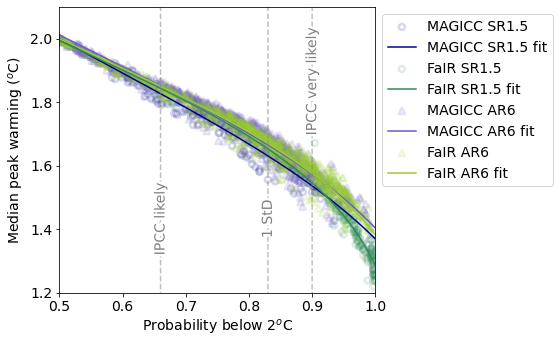

In [16]:
plt.figure(figsize = (8, 5))
edgewidth = 2.5
p0 = [1, 1, 5, 0.0]
xs = np.arange(1.2, 4, 0.01)
fringe = 0.0000005
results = []
interestingProbs = [0.66, 0.83, 0.9]
plotlist = [
        (magicc_pivot[magiccexceed2c], magicc_pivot[magiccmed], "MAGICC SR1.5", "darkblue", 0.16, "o"),
        (fair_pivot[fairexceed2c], fair_pivot[fairmed], "FaIR SR1.5", "seagreen", 0.16, "o"),
        (ar6magicc[ar6magiccexceed2c], ar6magicc[ar6magiccmed], "MAGICC AR6", "slateblue", 0.18, "^"), 
        (ar6fair[ar6fairexceed2c], ar6fair[ar6fairmed], "FaIR AR6", "yellowgreen", 0.16, "^"), 
    ]
for x, y, name, color, alpha, marker in plotlist:
    plt.scatter(
        1-x, y, edgecolors=color, facecolors="none", alpha=alpha, marker=marker, label=name, linewidths=edgewidth
    )
    popt, pcov = curve_fit(logistic_function, y.values, 1-x.values, p0=p0)
    L, k, x0, c = popt
    y_fit = logistic_function(xs, L, k, x0, c)
    results.append(pd.DataFrame({p : inverse_logistic(p, L, k, x0, c) for p in interestingProbs}, index=[name]))
    plt.plot(y_fit, xs, color=(color), label=name + " fit", linestyle="-", linewidth=1.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Probability below 2$^o$C")
plt.ylabel("Median peak warming ($^o$C)")
for x, label in [(0.66, "IPCC likely"), (0.83, "1 StD"), (0.9, "IPCC very likely")]:
    plt.plot([x, x+fringe], [1, 2.3], color="grey", linestyle="--", label=label, alpha=0.5)
lines = plt.gca().get_lines()
labelLines(lines[-3:], align=True, xvals=[0.66+fringe*1/3, 0.83+fringe*1/3, 0.90+fringe*2/3])
plt.ylim([1.2, 2.1])
plt.xlim([0.5, 1])
plt.tight_layout()
plt.savefig("./output/multifitTempProb.png", dpi=300, bbox_inches='tight')

In [17]:
results = pd.concat(results)

In [18]:
meanresult = results.loc[["MAGICC SR1.5", "FaIR SR1.5"], :].mean().to_frame().T
meanresult.index = ["SR1.5 mean"]
results = pd.concat([results, meanresult])
results

,0.66,0.83,0.90
MAGICC SR1.5,1.827192,1.631201,1.536881
FaIR SR1.5,1.844013,1.653483,1.545889
MAGICC AR6,1.851920,1.665973,1.573911
FaIR AR6,1.850934,1.670498,1.575885
SR1.5 mean,1.835603,1.642342,1.541385


In [19]:
results.round(3).to_csv("./output/ConversionResults.csv")

# Check if net zero date resolves the relationship

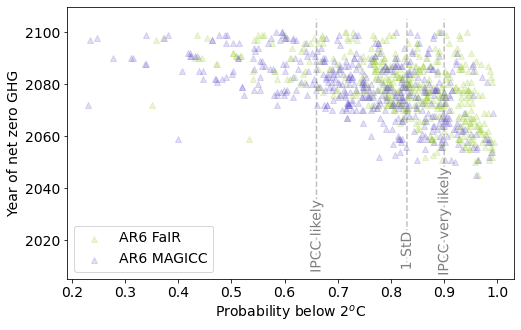

In [20]:
_, ax1 = plt.subplots(figsize=(8, 5))
plt.scatter(
    x=1-ar6meta[ar6fairexceed2c], 
    y=ar6meta["Year of netzero GHG emissions (Harm-Infilled) Table SPM2"],
    alpha=0.2, 
    label="AR6 FaIR",
    c="yellowgreen", 
    marker="^",
)
plt.scatter(
    x=1-ar6meta[ar6magiccexceed2c], 
    y=ar6meta["Year of netzero GHG emissions (Harm-Infilled) Table SPM2"], 
    alpha=0.2,
    label="AR6 MAGICC",
    c="slateblue", 
    marker="^",
)
plt.xlabel("Probability below 2$^o$C")
plt.ylabel("Year of net zero GHG")
for x, label in [(0.66, "IPCC likely"), (0.83, "1 StD"), (0.9, "IPCC very likely")]:
    plt.plot([x, x+fringe], [2010, 2105], color="grey", linestyle="--", label=label, alpha=0.5)
lines = plt.gca().get_lines()
# Add some fringe manipulation to get good placement of the labels:
labelLines(lines[-3:], align=True, xvals=[0.66+fringe*1.1/9, 0.83+fringe*1/16, 0.90+fringe*1.0/5.5])


# Plot only the first few legend items
# 1. Get all handles and labels from the current axes
handles, labels = ax1.get_legend_handles_labels()

# 2. Slice the lists to remove the last 3 items
filtered_handles = handles[:-3]
filtered_labels = labels[:-3]

# 3. Create the legend using only the filtered lists
ax1.legend(filtered_handles, filtered_labels, loc='best')
plt.savefig("./output/NetZeroWarmVsPeak.png", dpi=300, bbox_inches='tight')

In [21]:
# Which scenarios end so early?
nzGHG = "Year of netzero GHG emissions (Harm-Infilled) Table SPM2"
ar6meta.sort_values(nzGHG)

,Model,Scenario,Category,Category_name,Category_subset,Subset_Ch4,Category_Vetting_historical,IMP_marker,Literature Reference (if applicable),Policy_category,...,P67 peak warming (FaIRv1.6.2),Median warming in 2100 (FaIRv1.6.2),Median year of peak warming (FaIRv1.6.2),Exceedance Probability 1.5C (FaIRv1.6.2),Exceedance Probability 2.0C (FaIRv1.6.2),Exceedance Probability 3.0C (FaIRv1.6.2),IMP_color_rgb,IMP_color_hex,Category_color_rgb,Category_color_hex
157,C-ROADS-5.005,Ratchet-1.5-limCDR-noOS,C1,C1: limit warming to 1.5°C (>50%) with no or l...,C1a_NZGHGs,Limit to 1.5C (>50%) no or low OS immediate 20...,C1,non-IMP,https://doi.org/10.1088/1748-9326/aac0c1,P2,...,1.586255,1.192894,2038,0.467591,0.036209,0,NaN,NaN,"151, 206, 228",97CEE4
549,IMAGE 3.2,SSP1_SPA1_19I_LIRE_LB,C1,C1: limit warming to 1.5°C (>50%) with no or l...,C1a_NZGHGs,Limit to 1.5C (>50%) no or low OS immediate 20...,C1,non-IMP,https://doi.org/10.1016/j.energy.2021.121547; ...,P2,...,1.62368,1.235167,2037,0.523022,0.041574,0,NaN,NaN,"151, 206, 228",97CEE4
1179,REMIND-MAgPIE 1.7-3.0,PEP_1p5C_red_eff,C1,C1: limit warming to 1.5°C (>50%) with no or l...,C1a_NZGHGs,Limit to 1.5C (>50%) no or low OS immediate 20...,C1,non-IMP,https://doi.org/10.1088/1748-9326/aac4f1,P2,...,1.541335,1.107842,2036,0.396066,0.015199,0,NaN,NaN,"151, 206, 228",97CEE4
1038,REMIND 1.7,ADVANCE_2030_1.5C-2100,C2,C2: return warming to 1.5°C (>50%) after a hig...,C2,Limit 2C (>67%) or return to 1.5C (>50%) after...,C2,non-IMP,https://doi.org/10.1038/s41558-018-0198-6,P3b,...,1.754226,1.125598,2042,0.70675,0.104604,0,NaN,NaN,"119, 134, 99",778663
1126,REMIND-MAgPIE 1.5,SSP2-19,C1,C1: limit warming to 1.5°C (>50%) with no or l...,C1a_NZGHGs,Limit to 1.5C (>50%) no or low OS immediate 20...,C1,non-IMP,https://doi.org/10.1038/s41558-018-0091-3,P2a,...,1.608575,1.07565,2040,0.500671,0.038891,0,NaN,NaN,"151, 206, 228",97CEE4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,IMAGE 3.2,SSP1_SPA1_34I_LI,C5,C5: limit warming to 2.5°C (>50%),C5,NaN,C5,non-IMP,https://doi.org/10.1016/j.energy.2021.121547; ...,P2,...,2.283654,2.045325,2073,0.973178,0.599911,0.039338,NaN,NaN,"140, 167, 208",8CA7D0
556,IMAGE 3.2,SSP1_SPA1_34I_D,C5,C5: limit warming to 2.5°C (>50%),C5,NaN,C5,non-IMP,https://doi.org/10.1016/j.energy.2021.121547; ...,P2,...,2.188014,1.99534,2095,0.945016,0.5038,0.025928,NaN,NaN,"140, 167, 208",8CA7D0
554,IMAGE 3.2,SSP1_SPA1_26I_LIRE,C3,C3: limit warming to 2°C (>67%),C3y_+veGHGs,Limit to 2C (>67%) immediate 2020 action,C3,non-IMP,https://doi.org/10.1016/j.energy.2021.121547; ...,P2,...,1.902041,1.673542,2069,0.812696,0.23916,0.005364,NaN,NaN,"111, 120, 153",6F7899
580,IMAGE 3.2,SSP2_SPA2_45I_RE,C6,C6: limit warming to 3°C (>50%),C6,NaN,C6,non-IMP,https://doi.org/10.1016/j.energy.2021.121547; ...,P2,...,2.727931,2.495232,2100,0.997765,0.887796,0.179258,NaN,NaN,"250, 193, 130",FAC182


# Check how end century warming constrains peak warming

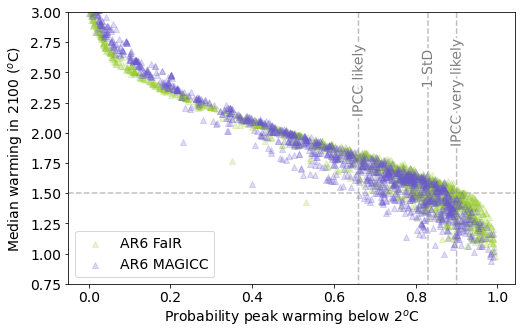

In [22]:
# Plot the relationship between end century warming and 2C avoidance in both MAGICC and FaIR
_, ax1 = plt.subplots(figsize=(8, 5))
plt.scatter(
    x=1-ar6meta[ar6fairexceed2c], 
    y=ar6meta['Median warming in 2100 (FaIRv1.6.2)'],
    alpha=0.22, 
    label="AR6 FaIR",
    c="yellowgreen", 
    marker="^",
)
plt.scatter(
    x=1-ar6meta[ar6magiccexceed2c], 
    y=ar6meta['Median warming in 2100 (MAGICCv7.5.3)'],
    alpha=0.22,
    label="AR6 MAGICC",
    c="slateblue", 
    marker="^",
)

plt.xlabel("Probability peak warming below 2$^o$C")
plt.ylabel("Median warming in 2100 ($^o$C)")
plt.ylim([0.75, 3])
for x, label in [(0.66, "IPCC likely"), (0.83, "1 StD"), (0.9, "IPCC very likely")]:
    plt.plot([x, x+fringe], [0, 4.5], color="grey", linestyle="--", label=label, alpha=0.5)
lines = plt.gca().get_lines()
labelLines(lines[-3:], align=True, xvals=[0.66+fringe*1/1.85, 0.83+fringe/1.78, 0.90+fringe*1.0/1.93])
plt.axhline(y=1.5, linestyle="--", color="grey", alpha=0.5)

# Plot only the first few legend items
# 1. Get all handles and labels from the current axes
handles, labels = ax1.get_legend_handles_labels()

# 2. Slice the lists to remove the last 3 items
filtered_handles = handles[:-3]
filtered_labels = labels[:-3]

# 3. Create the legend using only the filtered lists
ax1.legend(filtered_handles, filtered_labels, loc='best')
plt.savefig("./output/2100MedianWarmVs2Cavoidance.png", dpi=300, bbox_inches='tight')

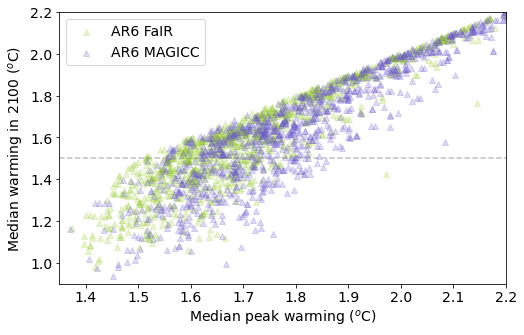

In [23]:
# Plot the relationship between end century warming and peak warming in both MAGICC and FaIR
_, ax1 = plt.subplots(figsize=(8, 5))
plt.scatter(
    x=ar6meta[ar6fairmed], 
    y=ar6meta['Median warming in 2100 (FaIRv1.6.2)'],
    alpha=0.22, 
    label="AR6 FaIR",
    c="yellowgreen", 
    marker="^",
)
plt.scatter(
    x=ar6meta[ar6magiccmed], 
    y=ar6meta['Median warming in 2100 (MAGICCv7.5.3)'],
    alpha=0.22,
    label="AR6 MAGICC",
    c="slateblue", 
    marker="^",
)

plt.xlabel("Median peak warming ($^o$C)")
plt.ylabel("Median warming in 2100 ($^o$C)")

plt.xlim([1.35, 2.2])
plt.ylim([0.9, 2.2])
ax1.legend(loc='best')
lines = plt.axhline(y=1.5, color="grey", linestyle="--", label=1.5, alpha=0.5)

plt.savefig("./output/2100MedianWarmVsPeak.png", dpi=300, bbox_inches='tight')

In [24]:
ar6meta[(ar6meta['Median warming in 2100 (FaIRv1.6.2)'] < 1.5) & (ar6meta[ar6fairexceed2c] > 0.33)]

,Model,Scenario,Category,Category_name,Category_subset,Subset_Ch4,Category_Vetting_historical,IMP_marker,Literature Reference (if applicable),Policy_category,...,P67 peak warming (FaIRv1.6.2),Median warming in 2100 (FaIRv1.6.2),Median year of peak warming (FaIRv1.6.2),Exceedance Probability 1.5C (FaIRv1.6.2),Exceedance Probability 2.0C (FaIRv1.6.2),Exceedance Probability 3.0C (FaIRv1.6.2),IMP_color_rgb,IMP_color_hex,Category_color_rgb,Category_color_hex
360,GCAM 5.3,SSP5-DACCS-1p9-3pctHR,failed-vetting,failed-vetting,C5,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1088/1748-9326/ac2db0,P2a,...,2.130613,1.423049,2058,0.957085,0.467591,0.008046,NaN,NaN,"140, 167, 208",8CA7D0


In [25]:
ar6meta[(ar6meta['Median warming in 2100 (FaIRv1.6.2)'] < 1.5) & (ar6meta[ar6fairexceed2c] > 0.33)]["Year of netzero GHG emissions (Harm-Infilled) Table SPM2"]

360    2059.0
Name: Year of netzero GHG emissions (Harm-Infilled) Table SPM2, dtype: float64

# Plot the relationship for 66%

In [26]:
magicc66_pivot = pd.pivot(magicc66.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
# get rid of annoying multiindex
magicc66_pivot.columns = [x[1] for x in magicc66_pivot.columns]
fair66_pivot = pd.pivot(fair66.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
fair66_pivot.columns = [x[1] for x in fair66_pivot.columns]
magicc66_pivot.head()

AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED  \
model       scenario               region                                                                
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                            1.537766             
            ADVANCE_2020_Med2C     World                                            1.965214             
            ADVANCE_2020_WB2C      World                                            1.607855             
            ADVANCE_2030_Med2C     World                                            2.139910             
            ADVANCE_2030_Price1.5C World                                            1.742394             

                                           AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|P66  
model       scenario               region                                                               
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                            1.658100            
            ADVANCE_2020_Med2C     World                                            2.183533            
            ADVANCE_2020_WB2C      World                                            1.746990            
            ADVANCE_2030_Med2C     World                                            2.379711            
            ADVANCE_2030_Price1.5C World                                            1.884542

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


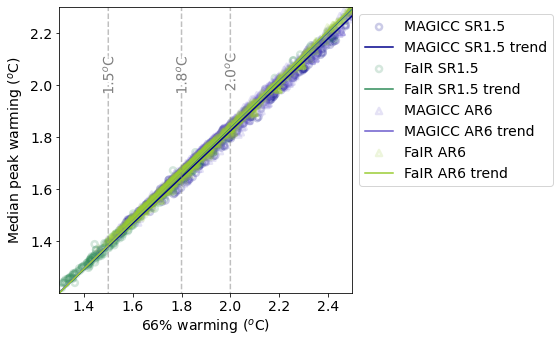

In [27]:
plt.figure(figsize = (8, 5))
edgewidth = 2.5
p0 = [1, 1, 5, 0.0]
xs = np.arange(1.2, 4, 0.01)
fringe = 0.0000005
results66 = []
plotlist = [
    (
        magicc66_pivot[magicc66variable], magicc66_pivot[magiccmed],
        "MAGICC SR1.5", "darkblue", 0.2, "o"
    ),
    (fair66_pivot[fair66variable], fair66_pivot[fairmed], "FaIR SR1.5", "seagreen", 0.2, "o"), 
    (
        ar6meta[ar6_magicc66variable].astype(float), ar6meta[ar6magiccmed].astype(float), 
        "MAGICC AR6", "slateblue", 0.17, "^"
    ),
    (
        ar6meta[ar6_fair66variable].astype(float), ar6meta[ar6fairmed].astype(float), 
        "FaIR AR6", "yellowgreen", 0.17, "^"
    ),
]
for x, y, name, color, alpha, marker in plotlist:
    plt.scatter(
        x, y, edgecolors=color, facecolors="none", alpha=alpha, marker=marker, 
        label=name, linewidths=edgewidth
    )
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    x_eval = np.array([1.5, 1.8, 2])
    y_predicted = slope * x_eval + intercept
    x_plot = np.array([1.3, 2.5])
    y_plot = slope * x_plot + intercept
    results66.append(
        pd.DataFrame({x_eval[i]: y_predicted[i] for i in range(len(x_eval))}, index=[name])
    )
    plt.plot(x_plot, y_plot, color=(color), label=name + " trend", linestyle="-")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("66% warming ($^o$C)")
plt.ylabel("Median peak warming ($^o$C)")
for x, label in [(1.5, "1.5$^o$C"), (1.8, "1.8$^o$C"), (2.0, "2.0$^o$C")]:
    plt.plot([x, x+fringe], [1, 2.3], color="grey", linestyle="--", label=label, alpha=0.5)
lines = plt.gca().get_lines()
labelLines(lines[-3:], align=True, xvals=[1.5+fringe*4/5, 1.8+fringe*4/5, 2+fringe*4.05/5,])
plt.ylim(y_plot)
plt.xlim(x_plot)
plt.tight_layout()
plt.savefig("./output/multifitTemp66Prob.png", dpi=300, bbox_inches='tight')

In [28]:
pd.concat(results66)

,1.5,1.8,2.0
MAGICC SR1.5,1.379406,1.645932,1.823616
FaIR SR1.5,1.383004,1.656731,1.839215
MAGICC AR6,1.385298,1.659401,1.842135
FaIR AR6,1.384178,1.659187,1.842527
